# Use top500 data and standardize for the models

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, make_scorer, log_loss
from sklearn.metrics import f1_score, roc_auc_score, balanced_accuracy_score
from sklearn import preprocessing
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.models import load_model
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [75]:
# get the  data set
df = pd.read_csv('../data/processed/all_top500-082919.csv', index_col = 'date')
X = df.drop(['RECESSION'], axis=1)
y = df['RECESSION']
X.head()

,B691RL1Q225SBEA,B020RG3Q086SBEA,A015RX1Q020SBEA,WPU028_diffQ,A640RC1Q027SBEA_diffMA,LFUNTTTTJPQ647S_diffQ,CUUR0000SAS367_diffA,LCEAMN01USQ189S_diffA,RECPROUSM156N_diffQ,CPGREN01JPQ659N,...,WPU112_diffA,WPU02_diffA,CUUR0000SAH1_diffA,USAPISPPR01GYQ,WPU1145_diffA,LNS12032197_diffQ,JPNPIEAMI02GPQ,CEU0500000006_diffMA,TRESEGJPM194N_diffA,WPU153_diffMA
date,,,,,,,,,,,,,,,,,,,,,
1969-01-01,0.260803,0.005504,0.672337,-0.062500,0.153846,-1.0,0.0,0.0,0.333333,0.292583,...,0.0,0.0,0.0,0.501777,0.0,0.000000,0.244749,-0.192630,0.0,1.000000
1969-02-01,0.260803,0.005504,0.672337,0.187500,0.034483,-1.0,0.0,0.0,0.000000,0.292583,...,0.0,1.0,1.0,0.501777,0.0,-0.393258,0.244749,-0.185198,1.0,0.764706
1969-03-01,0.154493,0.010985,0.690120,0.266667,-0.456522,0.0,1.0,0.0,-0.200000,0.287860,...,1.0,1.0,1.0,0.500654,1.0,1.000000,0.278906,-0.056687,1.0,0.500000
1969-04-01,0.154493,0.010985,0.690120,0.133333,-0.444444,0.0,1.0,0.0,1.000000,0.287860,...,1.0,1.0,1.0,0.500654,1.0,-0.514706,0.278906,0.133964,0.0,0.304348
1969-05-01,0.154493,0.010985,0.690120,-0.105263,-0.431818,0.0,1.0,0.0,1.000000,0.287860,...,1.0,1.0,1.0,0.500654,1.0,0.722222,0.278906,0.240708,0.0,1.000000


In [12]:
# mid-point between recessions

mid1_2 = '1971-05-01'
mid2_3 = '1977-08-01'
mid3_4 = '1980-11-01'
mid4_5 = '1986-09-01'
mid5_6 = '1996-03-01'
mid6_7 = '2004-11-01'
mid7_8 = '2014-04-01'

In [88]:
# run this to train on first 5 recessions
X_train = X.loc[:mid5_6]
y_train = y.loc[:mid5_6]
X_test = X.loc[mid5_6:]
y_test = y.loc[mid5_6:]

In [76]:
# run this to train on first 6 recessions CURRENT PLAN
X_train = X.loc[:mid6_7]
y_train = y.loc[:mid6_7]
# X_test = X.loc[mid6_7:]
# y_test = y.loc[mid6_7:]

In [120]:
# run this to train on all 7 recessions (for production?)
X_train = X.loc[:mid7_8]
y_train = y.loc[:mid7_8]
X_test = X.loc[mid7_8:]
y_test = y.loc[mid7_8:]

In [77]:
# standardize data here
# fit scaler on training data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train = pd.DataFrame(data=X_train_scaled, index=X_train.index, columns=X_train.columns)

# transform entire dataset based on training data
X_scaled = scaler.transform(X)
X = pd.DataFrame(data=X_scaled, index=X.index, columns=X.columns)
X_test = X.loc[mid6_7:]
y_test = y.loc[mid6_7:]

X.head()

,B691RL1Q225SBEA,B020RG3Q086SBEA,A015RX1Q020SBEA,WPU028_diffQ,A640RC1Q027SBEA_diffMA,LFUNTTTTJPQ647S_diffQ,CUUR0000SAS367_diffA,LCEAMN01USQ189S_diffA,RECPROUSM156N_diffQ,CPGREN01JPQ659N,...,WPU112_diffA,WPU02_diffA,CUUR0000SAH1_diffA,USAPISPPR01GYQ,WPU1145_diffA,LNS12032197_diffQ,JPNPIEAMI02GPQ,CEU0500000006_diffMA,TRESEGJPM194N_diffA,WPU153_diffMA
date,,,,,,,,,,,,,,,,,,,,,
1969-01-01,-0.543028,-2.30846,-0.022273,-0.873106,0.735219,-4.991536,-0.797902,-0.718006,0.467847,-0.092436,...,-0.604721,-0.519816,-0.705849,-0.121993,-0.610845,-0.093386,-0.101358,-2.290669,-0.732747,6.095418
1969-02-01,-0.543028,-2.30846,-0.022273,1.528738,-0.195369,-4.991536,-0.797902,-0.718006,0.022643,-0.092436,...,-0.604721,3.385350,4.527699,-0.121993,-0.610845,-2.459492,-0.101358,-2.216937,2.458690,4.580569
1969-03-01,-1.478326,-2.28450,0.151669,2.289322,-4.023370,-0.097071,4.792205,-0.718006,-0.244479,-0.130817,...,3.932318,3.385350,4.527699,-0.130285,3.938570,5.923282,0.283884,-0.942028,2.458690,2.876364
1969-04-01,-1.478326,-2.28450,0.151669,1.008338,-3.929212,-0.097071,4.792205,-0.718006,1.358253,-0.130817,...,3.932318,3.385350,4.527699,-0.130285,3.938570,-3.190201,0.283884,0.949358,-0.732747,1.616734
1969-05-01,-1.478326,-2.28450,0.151669,-1.283948,-3.830774,-0.097071,4.792205,-0.718006,1.358253,-0.130817,...,3.932318,3.385350,4.527699,-0.130285,3.938570,4.251985,0.283884,2.008330,-0.732747,6.095418


In [14]:
# split for CV
X1_train = X.loc[mid1_2:mid6_7]
y1_train = y.loc[mid1_2:mid6_7]
X1_test = X.loc[:mid1_2].iloc[:-1]
y1_test = y.loc[:mid1_2].iloc[:-1]

X2_train = X.loc[:mid1_2] + X.loc[mid2_3:mid6_7]
y2_train = y.loc[:mid1_2] + y.loc[mid2_3:mid6_7]
X2_test = X.loc[mid1_2:mid2_3].iloc[1:-1]
y2_test = y.loc[mid1_2:mid2_3].iloc[1:-1]

X3_train = X.loc[:mid2_3] + X.loc[mid3_4:mid6_7]
y3_train = y.loc[:mid2_3] + y.loc[mid3_4:mid6_7]
X3_test = X.loc[mid2_3:mid3_4].iloc[1:-1]
y3_test = y.loc[mid2_3:mid3_4].iloc[1:-1]

X4_train = X.loc[:mid3_4] + X.loc[mid4_5:mid6_7]
y4_train = y.loc[:mid3_4] + y.loc[mid4_5:mid6_7]
X4_test = X.loc[mid3_4:mid4_5].iloc[1:-1]
y4_test = y.loc[mid3_4:mid4_5].iloc[1:-1]

X5_train = X.loc[:mid4_5] + X.loc[mid5_6:mid6_7]
y5_train = y.loc[:mid4_5] + y.loc[mid5_6:mid6_7]
X5_test = X.loc[mid4_5:mid5_6].iloc[1:-1]
y5_test = y.loc[mid4_5:mid5_6].iloc[1:-1]

X6_train = X.loc[:mid5_6]
y6_train = y.loc[:mid5_6]
X6_test = X.loc[mid5_6:mid6_7].iloc[1:-1]
y6_test = y.loc[mid5_6:mid6_7].iloc[1:-1]

X1_train_i = pd.Index([X.index.get_loc(i) for i in X1_train.index])
X1_test_i = pd.Index([X.index.get_loc(i) for i in X1_test.index])

X2_train_i = pd.Index([X.index.get_loc(i) for i in X2_train.index])
X2_test_i = pd.Index([X.index.get_loc(i) for i in X2_test.index])

X3_train_i = pd.Index([X.index.get_loc(i) for i in X3_train.index])
X3_test_i = pd.Index([X.index.get_loc(i) for i in X3_test.index])

X4_train_i = pd.Index([X.index.get_loc(i) for i in X4_train.index])
X4_test_i = pd.Index([X.index.get_loc(i) for i in X4_test.index])

X5_train_i = pd.Index([X.index.get_loc(i) for i in X5_train.index])
X5_test_i = pd.Index([X.index.get_loc(i) for i in X5_test.index])

X6_train_i = pd.Index([X.index.get_loc(i) for i in X6_train.index])
X6_test_i = pd.Index([X.index.get_loc(i) for i in X6_test.index])

mankf = [[X1_train_i, X1_test_i], [X2_train_i, X2_test_i], [X3_train_i, X3_test_i], [X4_train_i, X4_test_i],\
         [X5_train_i, X5_test_i], [X6_train_i, X6_test_i]]

In [15]:
# custom scoring function v2
def my_score(y_test, y_pred):
    y_test2 = list(y_test)
    y_pred2 = list(y_pred)
    max_y_index = len(y_test2)
    first_1 = True
    for i, val in enumerate(y_test2):
        if val == 0 and (1 not in y_test2[i:min(i+4, max_y_index)]) and y_pred2[i] == 1:
            return 0
        elif val == 0:
            first_1 = True
        elif first_1 == True and val == 1:
            if 1 not in y_pred[max(0,i-3):min(i+6,max_y_index)]:
                return 0
            else:
                first_1 = False
    return balanced_accuracy_score(y_test2, y_pred2)
custom_score = make_scorer(my_score)

In [11]:
# run a test set
ytest = [0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0]
ypred = [0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]
my_score(ytest,ypred)

0.5416666666666666

In [78]:
lrc = LogisticRegression(random_state=42)
p_grid = [
    {'penalty':['l2', 'none'],
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
     'class_weight': ['balanced', None],
     'C': [0.1, 1.0, 10.0]
     }
]

In [79]:
clf = GridSearchCV(estimator=lrc, cv=mankf, param_grid=p_grid, scoring={'nll':'neg_log_loss','custom':custom_score}, refit='nll')
clf.fit(X,y)
print(clf.best_params_)
gsdf = pd.DataFrame(clf.cv_results_)
gsdf[gsdf.rank_test_custom < 20]

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_penalty,param_solver,params,split0_test_nll,...,rank_test_nll,split0_test_custom,split1_test_custom,split2_test_custom,split3_test_custom,split4_test_custom,split5_test_custom,mean_test_custom,std_test_custom,rank_test_custom
0,0.240601,0.145976,0.003171,0.000898,0.1,balanced,l2,newton-cg,"{'C': 0.1, 'class_weight': 'balanced', 'penalt...",-0.161964,...,2,0.0,0.666667,0.0,0.000000,0.0,0.0,0.107300,0.244990,9
1,0.060296,0.009874,0.002995,0.000005,0.1,balanced,l2,lbfgs,"{'C': 0.1, 'class_weight': 'balanced', 'penalt...",-0.162020,...,1,0.0,0.666667,0.0,0.000000,0.0,0.0,0.107300,0.244990,9
2,0.444412,0.028832,0.006828,0.009030,0.1,balanced,l2,sag,"{'C': 0.1, 'class_weight': 'balanced', 'penalt...",-15.381441,...,19,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,13
3,0.668525,0.062719,0.002664,0.000473,0.1,balanced,l2,saga,"{'C': 0.1, 'class_weight': 'balanced', 'penalt...",-15.307892,...,13,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,13
4,0.154994,0.030425,0.002834,0.000368,0.1,balanced,none,newton-cg,"{'C': 0.1, 'class_weight': 'balanced', 'penalt...",-21.530846,...,37,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,13
5,0.023985,0.001153,0.002331,0.000472,0.1,balanced,none,lbfgs,"{'C': 0.1, 'class_weight': 'balanced', 'penalt...",-21.381643,...,43,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,13
6,0.414935,0.034471,0.003159,0.000895,0.1,balanced,none,sag,"{'C': 0.1, 'class_weight': 'balanced', 'penalt...",-17.687274,...,22,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,13
7,0.653547,0.116029,0.002996,0.003358,0.1,balanced,none,saga,"{'C': 0.1, 'class_weight': 'balanced', 'penalt...",-16.370900,...,16,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,13
8,0.209859,0.030206,0.000000,0.000000,0.1,None,l2,newton-cg,"{'C': 0.1, 'class_weight': None, 'penalty': 'l...",-0.105788,...,4,1.0,0.666667,0.0,0.000000,0.0,0.0,0.162709,0.316967,7
9,0.063331,0.011359,0.002998,0.000002,0.1,None,l2,lbfgs,"{'C': 0.1, 'class_weight': None, 'penalty': 'l...",-0.105798,...,3,1.0,0.666667,0.0,0.000000,0.0,0.0,0.162709,0.316967,7


In [80]:
# tuned on log_loss
lr_clf = LogisticRegression(random_state=42, solver='lbfgs', multi_class='ovr', C=0.1, class_weight='balanced', penalty='l2')
lr_clf.fit(X_train, y_train)
log_loss(y_test, lr_clf.predict_proba(X_test))

0.034281466720920306

In [132]:
# tuned on custom score
lr_clf = LogisticRegression(random_state=42, solver='sag', multi_class='ovr', C=0.1, class_weight=None, penalty='l2')
lr_clf.fit(X_train, y_train)
log_loss(y_test, lr_clf.predict_proba(X_test))

0.06024532685905338

In [229]:
lr_pred_proba = lr_clf.predict_proba(X_test)
lr_pred = lr_clf.predict(X_test)

In [20]:
j=1969
xt=[]
xtl=[]
for i,yr in enumerate(list(pd.to_datetime(y.index).year)):
    if yr==j:
        xt.append(i)
        xtl.append(yr)
        j += 2
        

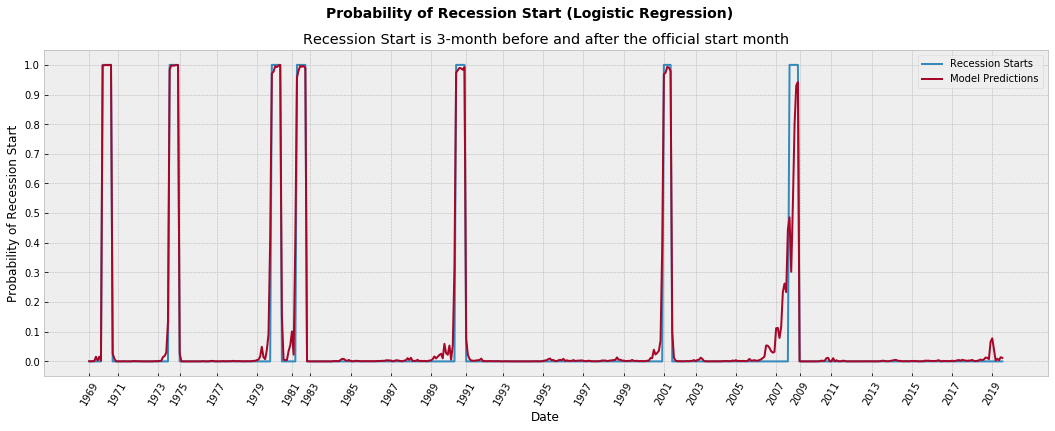

In [81]:
y_pred = lr_clf.predict_proba(X)[:,1]
mpl.style.use('bmh')
fig = plt.figure(figsize=(18,6))
fig.suptitle('Probability of Recession Start (Logistic Regression)', fontsize=14, fontweight='bold')
ax = fig.add_subplot()
ax.set_title('Recession Start is 3-month before and after the official start month')
ax.plot(y.values, label="Recession Starts")
ax.plot(y_pred, label="Model Predictions")
ax.set_xlabel("Date")
ax.set_ylabel("Probability of Recession Start")
ax.locator_params(axis='y', tight=True, min_n_ticks=11)
ax.set_xticks(xt)
ax.set_xticklabels(xtl)
ax.tick_params(axis='x', labelrotation=60)
ax.legend()
plt.show()

In [226]:
rfc = RandomForestClassifier()
p_grid = [
    {'n_estimators': [10, 100, 1000],
     'max_depth': [4, 2, None],
     'min_samples_split': [2, 4, 10],
     'criterion': ['gini', 'entropy'],
     'min_samples_leaf':[1, 2],
     'max_features':['sqrt', None],
     'class_weight':['balanced', None]
     }
]
clf = GridSearchCV(estimator=rfc, cv=mankf, param_grid=p_grid, scoring={'nll':'neg_log_loss','custom':custom_score}, refit='nll')
clf.fit(X,y)
print(clf.best_params_)
gsrfdf = pd.DataFrame(clf.cv_results_)
gsrfdf[gsrfdf.rank_test_nll <= 20]

{'class_weight': None, 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,...,rank_test_nll,split0_test_custom,split1_test_custom,split2_test_custom,split3_test_custom,split4_test_custom,split5_test_custom,mean_test_custom,std_test_custom,rank_test_custom
81,0.024986,0.001294,0.005330,0.000471,balanced,gini,None,sqrt,2,2,...,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,432
220,0.254052,0.026745,0.017322,0.000472,None,gini,4,sqrt,1,4,...,4,0.800000,1.000000,0.916667,0.000000,0.000000,0.0,0.289930,0.435833,158
222,0.030840,0.003524,0.005663,0.000471,None,gini,4,sqrt,1,10,...,2,0.833333,0.990909,0.833333,0.583333,0.000000,0.0,0.368809,0.418215,13
225,0.031147,0.003577,0.005162,0.000373,None,gini,4,sqrt,2,2,...,3,0.800000,0.000000,0.000000,0.000000,0.000000,0.0,0.044327,0.183021,429
226,0.253688,0.025902,0.017484,0.000495,None,gini,4,sqrt,2,2,...,1,0.716667,1.000000,0.916667,0.000000,0.000000,0.0,0.285312,0.430817,171
227,2.483571,0.274380,0.136254,0.004532,None,gini,4,sqrt,2,2,...,7,0.800000,1.000000,0.916667,0.000000,0.000000,0.0,0.289930,0.435833,158
229,0.251605,0.030064,0.016989,0.000578,None,gini,4,sqrt,2,4,...,13,0.716667,1.000000,0.916667,0.000000,0.000000,0.0,0.285312,0.430817,171
230,2.488585,0.260576,0.135425,0.005796,None,gini,4,sqrt,2,4,...,16,0.800000,1.000000,0.916667,0.000000,0.000000,0.0,0.289930,0.435833,158
290,2.753738,0.403560,0.134093,0.003021,None,gini,None,sqrt,1,2,...,15,0.966667,0.990909,0.916667,0.000000,0.000000,0.0,0.297701,0.445854,143
295,0.277534,0.036284,0.017324,0.000745,None,gini,None,sqrt,1,10,...,8,0.966667,1.000000,0.916667,0.750000,0.000000,0.0,0.409982,0.453158,6


In [206]:
gsrfdf[gsrfdf.rank_test_custom <= 20].iloc[:,5:30]

,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_nll,split1_test_nll,split2_test_nll,...,rank_test_nll,split0_test_custom,split1_test_custom,split2_test_custom,split3_test_custom,split4_test_custom,split5_test_custom,mean_test_custom,std_test_custom,rank_test_custom
163,entropy,2,None,1,2,100,"{'class_weight': 'balanced', 'criterion': 'ent...",-0.387490,-0.202622,-0.182059,...,240,0.933333,0.666667,0.916667,0.750000,0.000000,0.0,0.354485,0.393513,17
165,entropy,2,None,1,4,10,"{'class_weight': 'balanced', 'criterion': 'ent...",-0.340854,-0.164058,-1.135324,...,391,0.900000,0.666667,0.666667,0.750000,0.495098,0.0,0.470635,0.298202,5
166,entropy,2,None,1,4,100,"{'class_weight': 'balanced', 'criterion': 'ent...",-0.404961,-0.230575,-0.199987,...,251,0.683333,0.666667,0.916667,0.833333,0.000000,0.0,0.352946,0.391206,18
168,entropy,2,None,1,10,10,"{'class_weight': 'balanced', 'criterion': 'ent...",-0.337920,-0.685917,-1.131147,...,423,0.933333,0.666667,0.833333,0.980000,0.000000,0.0,0.380774,0.425263,11
217,gini,4,sqrt,1,2,100,"{'class_weight': None, 'criterion': 'gini', 'm...",-0.412346,-0.160621,-0.223404,...,153,0.933333,0.990909,0.916667,0.583333,0.000000,0.0,0.382046,0.433845,9
234,gini,4,None,1,2,10,"{'class_weight': None, 'criterion': 'gini', 'm...",-0.500548,-0.122275,-0.227165,...,403,0.516667,0.990909,0.000000,0.750000,0.583333,0.0,0.465160,0.369505,6
236,gini,4,None,1,2,1000,"{'class_weight': None, 'criterion': 'gini', 'm...",-0.446931,-0.099165,-0.154778,...,77,0.683333,0.000000,0.000000,0.833333,0.666667,0.0,0.350967,0.363253,19
238,gini,4,None,1,4,100,"{'class_weight': None, 'criterion': 'gini', 'm...",-0.467318,-0.076576,-0.173403,...,339,0.516667,1.000000,0.000000,0.833333,0.583333,0.0,0.478936,0.382016,4
239,gini,4,None,1,4,1000,"{'class_weight': None, 'criterion': 'gini', 'm...",-0.436006,-0.091078,-0.151108,...,80,0.683333,0.000000,0.000000,0.833333,0.666667,0.0,0.350967,0.363253,19
242,gini,4,None,1,10,1000,"{'class_weight': None, 'criterion': 'gini', 'm...",-0.431645,-0.097341,-0.153198,...,51,0.683333,0.000000,0.000000,0.833333,0.666667,0.0,0.350967,0.363253,19


In [227]:
# tuned on log loss
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=4, min_samples_split=2, random_state=42, class_weight=None,\
                               criterion='gini', max_features='sqrt', min_samples_leaf=2)
rf_clf.fit(X_train, y_train)
log_loss(y_test, rf_clf.predict_proba(X_test))

0.12750926160113438

In [194]:
# tuned on custom
rf_clf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=42, class_weight=None,\
                               criterion='gini', max_features=None, min_samples_leaf=2)
rf_clf.fit(X_train, y_train)
log_loss(y_test, rf_clf.predict_proba(X_test))

0.13940514167791793

In [230]:
rf_pred_proba = rf_clf.predict_proba(X_test)
rf_pred = rf_clf.predict(X_test)

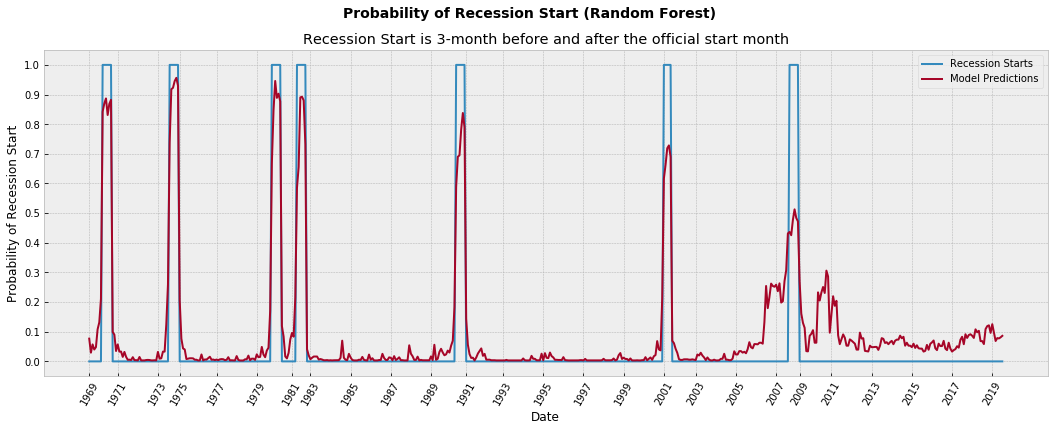

In [228]:
y_pred = rf_clf.predict_proba(X)[:,1]
fig = plt.figure(figsize=(18,6))
fig.suptitle('Probability of Recession Start (Random Forest)', fontsize=14, fontweight='bold')
ax = fig.add_subplot()
ax.set_title('Recession Start is 3-month before and after the official start month')
ax.plot(y.values, label="Recession Starts")
ax.plot(y_pred, label="Model Predictions")
ax.set_xlabel("Date")
ax.set_ylabel("Probability of Recession Start")
ax.locator_params(axis='y', tight=True, min_n_ticks=11)
ax.set_xticks(xt)
ax.set_xticklabels(xtl)
ax.tick_params(axis='x', labelrotation=60)
ax.legend()
plt.show()

In [82]:
svc = SVC(random_state=42, probability=True)
p_grid = [
    {'kernel': ['poly', 'sigmoid', 'rbf'],
     'C': [0.1, 1.0, 10.0],
     'gamma':['auto', 'scale'],
     'shrinking': [True, False],
     'class_weight':['balanced', None],
     'decision_function_shape':['ovo', 'ovr']
     }
]
clf = GridSearchCV(estimator=svc, cv=mankf, param_grid=p_grid, scoring={'nll':'neg_log_loss','custom':custom_score}, refit='nll')
clf.fit(X,y)
print(clf.best_params_)
gssvc_df = pd.DataFrame(clf.cv_results_)
gssvc_df[gssvc_df.rank_test_custom < 20]

{'C': 1.0, 'class_weight': None, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'rbf', 'shrinking': True}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_decision_function_shape,param_gamma,param_kernel,param_shrinking,...,rank_test_nll,split0_test_custom,split1_test_custom,split2_test_custom,split3_test_custom,split4_test_custom,split5_test_custom,mean_test_custom,std_test_custom,rank_test_custom
0,0.650251,0.160940,0.048843,0.016162,0.1,balanced,ovo,auto,poly,True,...,109,0.0,1.000000,0.0,0.000000,0.0,0.0,0.160950,0.367485,1
1,0.628888,0.174198,0.049813,0.022043,0.1,balanced,ovo,auto,poly,False,...,111,0.0,1.000000,0.0,0.000000,0.0,0.0,0.160950,0.367485,1
4,0.641063,0.123061,0.046474,0.018103,0.1,balanced,ovo,auto,rbf,True,...,37,0.0,0.000000,0.0,0.583333,0.0,0.0,0.086192,0.207001,17
5,0.613224,0.107193,0.045643,0.018544,0.1,balanced,ovo,auto,rbf,False,...,37,0.0,0.000000,0.0,0.583333,0.0,0.0,0.086192,0.207001,17
6,0.607419,0.103624,0.046972,0.022189,0.1,balanced,ovo,scale,poly,True,...,121,0.0,0.981818,0.0,0.000000,0.0,0.0,0.158024,0.360803,5
7,0.667350,0.157299,0.046507,0.019418,0.1,balanced,ovo,scale,poly,False,...,121,0.0,0.981818,0.0,0.000000,0.0,0.0,0.158024,0.360803,5
12,0.582421,0.134552,0.042147,0.015586,0.1,balanced,ovr,auto,poly,True,...,109,0.0,1.000000,0.0,0.000000,0.0,0.0,0.160950,0.367485,1
13,0.577602,0.139849,0.041986,0.015309,0.1,balanced,ovr,auto,poly,False,...,111,0.0,1.000000,0.0,0.000000,0.0,0.0,0.160950,0.367485,1
16,0.610557,0.103966,0.045516,0.019075,0.1,balanced,ovr,auto,rbf,True,...,37,0.0,0.000000,0.0,0.583333,0.0,0.0,0.086192,0.207001,17
17,0.611730,0.103997,0.047974,0.021114,0.1,balanced,ovr,auto,rbf,False,...,37,0.0,0.000000,0.0,0.583333,0.0,0.0,0.086192,0.207001,17


In [163]:
# tuned to custom score
svc_clf = SVC(random_state=2, C=10.0, class_weight=None, decision_function_shape='ovr', gamma='auto',\
             kernel='rbf', shrinking=True, probability=True)
svc_clf.fit(X_train, y_train)
log_loss(y_test, svc_clf.predict_proba(X_test))

0.038922362700830875

In [83]:
# tuned to log_loss
svc_clf = SVC(random_state=42, C=1.0, class_weight=None, decision_function_shape='ovo', gamma='auto',\
             kernel='rbf', shrinking=True, probability=True)
svc_clf.fit(X_train, y_train)
log_loss(y_test, svc_clf.predict_proba(X_test))

0.09204721279591754

In [231]:
sv_pred_proba = svc_clf.predict_proba(X_test)
sv_pred = svc_clf.predict(X_test)
sv_pred = [1 if x>=0.5 else 0 for x in sv_pred_proba[:,1]]

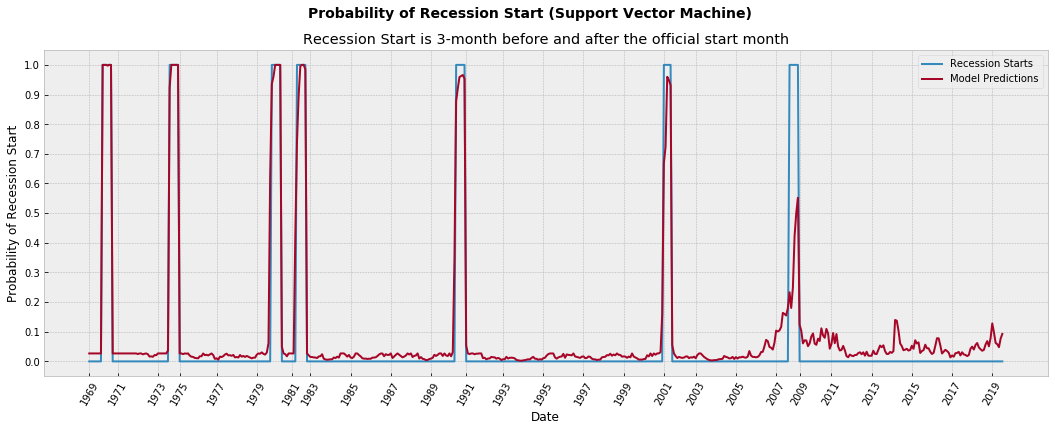

In [84]:
y_pred = svc_clf.predict_proba(X)[:,1]
fig = plt.figure(figsize=(18,6))
fig.suptitle('Probability of Recession Start (Support Vector Machine)', fontsize=14, fontweight='bold')
ax = fig.add_subplot()
ax.set_title('Recession Start is 3-month before and after the official start month')
ax.plot(y.values, label="Recession Starts")
ax.plot(y_pred, label="Model Predictions")
ax.set_xlabel("Date")
ax.set_ylabel("Probability of Recession Start")
ax.locator_params(axis='y', tight=True, min_n_ticks=11)
ax.set_xticks(xt)
ax.set_xticklabels(xtl)
ax.tick_params(axis='x', labelrotation=60)
ax.legend()
plt.show()

In [85]:
knc = KNeighborsClassifier()
p_grid = [
    {'n_neighbors': [1, 3, 5, 10, 20],
     'weights': ['uniform', 'distance'],
     'algorithm':['ball_tree', 'kd_tree', 'brute'],
     'leaf_size': [30, 50],
     'p':[1, 2],
      }
]
clf = GridSearchCV(estimator=knc, cv=mankf, param_grid=p_grid, scoring={'nll':'neg_log_loss','custom':custom_score}, refit='nll')
clf.fit(X,y)
print(clf.best_params_)
gskn_df = pd.DataFrame(clf.cv_results_)
gskn_df[gskn_df.rank_test_nll < 20]

{'algorithm': 'ball_tree', 'leaf_size': 30, 'n_neighbors': 20, 'p': 2, 'weights': 'distance'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_n_neighbors,param_p,param_weights,params,...,rank_test_nll,split0_test_custom,split1_test_custom,split2_test_custom,split3_test_custom,split4_test_custom,split5_test_custom,mean_test_custom,std_test_custom,rank_test_custom
16,0.014158,6.868647e-04,0.061465,0.023873,ball_tree,30,20,1,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n...",...,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97
17,0.013992,8.160481e-04,0.061632,0.023606,ball_tree,30,20,1,distance,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n...",...,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97
18,0.014658,9.420242e-04,0.062298,0.024301,ball_tree,30,20,2,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n...",...,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97
19,0.014663,1.367992e-03,0.060461,0.023868,ball_tree,30,20,2,distance,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n...",...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97
36,0.011993,9.996892e-04,0.061632,0.022597,ball_tree,50,20,1,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 50, 'n...",...,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97
37,0.012159,1.066682e-03,0.059675,0.023302,ball_tree,50,20,1,distance,"{'algorithm': 'ball_tree', 'leaf_size': 50, 'n...",...,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97
38,0.013159,1.212980e-03,0.061799,0.023583,ball_tree,50,20,2,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 50, 'n...",...,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97
39,0.012992,1.526608e-03,0.060799,0.023674,ball_tree,50,20,2,distance,"{'algorithm': 'ball_tree', 'leaf_size': 50, 'n...",...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97
56,0.015491,9.567767e-04,0.077289,0.033535,kd_tree,30,20,1,uniform,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'n_n...",...,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97
57,0.015657,9.422069e-04,0.074988,0.030693,kd_tree,30,20,1,distance,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'n_n...",...,13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,97


In [86]:
gskn_df[gskn_df.rank_test_custom == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_leaf_size,param_n_neighbors,param_p,param_weights,params,...,rank_test_nll,split0_test_custom,split1_test_custom,split2_test_custom,split3_test_custom,split4_test_custom,split5_test_custom,mean_test_custom,std_test_custom,rank_test_custom
6,0.015491,0.001384,0.062964,0.024083,ball_tree,30,3,2,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n...",...,67,1.0,0.916667,0.0,0.583333,0.0,0.0,0.289138,0.396648,1
7,0.015658,0.001598,0.061491,0.023571,ball_tree,30,3,2,distance,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n...",...,61,1.0,0.916667,0.0,0.583333,0.0,0.0,0.289138,0.396648,1
10,0.015651,0.001377,0.062965,0.024932,ball_tree,30,5,2,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n...",...,55,1.0,0.916667,0.0,0.583333,0.0,0.0,0.289138,0.396648,1
11,0.015824,0.001771,0.062299,0.024039,ball_tree,30,5,2,distance,"{'algorithm': 'ball_tree', 'leaf_size': 30, 'n...",...,49,1.0,0.916667,0.0,0.583333,0.0,0.0,0.289138,0.396648,1
26,0.012659,0.000942,0.061994,0.023137,ball_tree,50,3,2,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 50, 'n...",...,67,1.0,0.916667,0.0,0.583333,0.0,0.0,0.289138,0.396648,1
27,0.012326,0.001105,0.059467,0.022546,ball_tree,50,3,2,distance,"{'algorithm': 'ball_tree', 'leaf_size': 50, 'n...",...,61,1.0,0.916667,0.0,0.583333,0.0,0.0,0.289138,0.396648,1
30,0.014825,0.004138,0.064963,0.024979,ball_tree,50,5,2,uniform,"{'algorithm': 'ball_tree', 'leaf_size': 50, 'n...",...,55,1.0,0.916667,0.0,0.583333,0.0,0.0,0.289138,0.396648,1
31,0.013159,0.001462,0.060831,0.023342,ball_tree,50,5,2,distance,"{'algorithm': 'ball_tree', 'leaf_size': 50, 'n...",...,49,1.0,0.916667,0.0,0.583333,0.0,0.0,0.289138,0.396648,1
46,0.016823,0.000897,0.108938,0.048589,kd_tree,30,3,2,uniform,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'n_n...",...,67,1.0,0.916667,0.0,0.583333,0.0,0.0,0.289138,0.396648,1
47,0.016990,0.002449,0.099777,0.038146,kd_tree,30,3,2,distance,"{'algorithm': 'kd_tree', 'leaf_size': 30, 'n_n...",...,61,1.0,0.916667,0.0,0.583333,0.0,0.0,0.289138,0.396648,1


In [30]:
# tuned to custom score
kn_clf = KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, n_neighbors=1, p=2, weights='uniform')
kn_clf.fit(X_train, y_train)
log_loss(y_test, kn_clf.predict_proba(X_test))

1.2792139405522482

In [87]:
# tuned to log_loss
kn_clf = KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, n_neighbors=20, p=2, weights='distance')
kn_clf.fit(X_train, y_train)
log_loss(y_test, kn_clf.predict_proba(X_test))

0.676126755041637

In [232]:
kn_pred_proba = kn_clf.predict_proba(X_test)
kn_pred = kn_clf.predict(X_test)

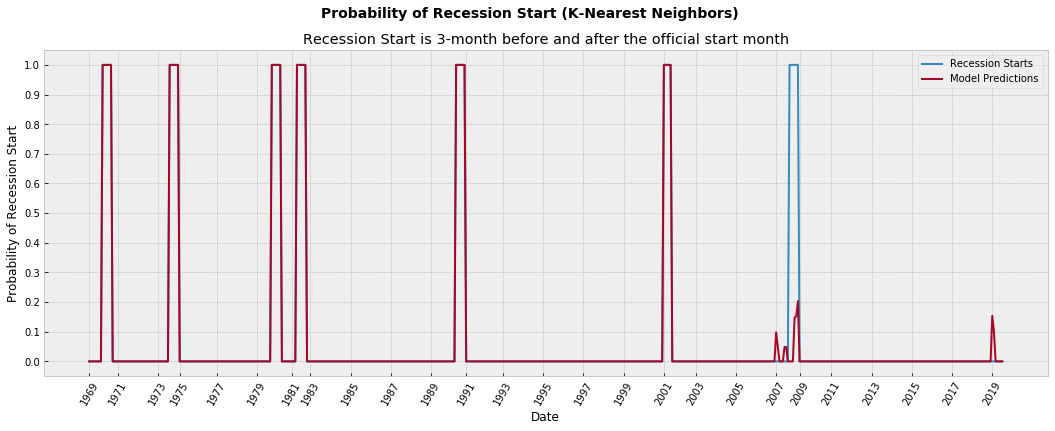

In [88]:
y_pred = kn_clf.predict_proba(X)[:,1]
fig = plt.figure(figsize=(18,6))
fig.suptitle('Probability of Recession Start (K-Nearest Neighbors)', fontsize=14, fontweight='bold')
ax = fig.add_subplot()
ax.set_title('Recession Start is 3-month before and after the official start month')
ax.plot(y.values, label="Recession Starts")
ax.plot(y_pred, label="Model Predictions")
ax.set_xlabel("Date")
ax.set_ylabel("Probability of Recession Start")
ax.locator_params(axis='y', tight=True, min_n_ticks=11)
ax.set_xticks(xt)
ax.set_xticklabels(xtl)
ax.tick_params(axis='x', labelrotation=60)
ax.legend()
plt.show()

In [89]:
# scale data to min max of -1, 1, for the neural network
mmscaler = preprocessing.MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_minmax = mmscaler.transform(X)
Xmm = pd.DataFrame(data=X_minmax, index=X.index, columns=X.columns)
Xmm_train = Xmm.loc[:mid6_7]
Xmm_test = Xmm.loc[mid6_7:]

In [90]:
# neural network model
n_cols = X.shape[1]
input_shape = (n_cols,)
target = to_categorical(y_train)
predictors = Xmm_train.values

In [39]:



def get_new_model(input_shape = input_shape):     
    model = Sequential()     
    model.add(Dense(1000, activation='relu', input_shape = input_shape))     
    model.add(Dense(1000, activation='relu'))     
    model.add(Dense(2, activation='softmax'))     
    return(model) 

# Create list of learning rates: lr_to_test
lr_to_test = [.000001, 0.0001, .001]

# Loop over learning rates
for lr in lr_to_test:
    print('\n\nTesting model with learning rate: %f\n'%lr )
    
    # Build new model to test, unaffected by previous models
    model = get_new_model()
    
    # Create SGD optimizer with specified learning rate: my_optimizer
    my_optimizer = SGD(lr=lr)
    
    # Compile the model
    model.compile(optimizer=my_optimizer, loss='categorical_crossentropy')
    
    # Fit the model
    model.fit(predictors, target, epochs=10)



Testing model with learning rate: 0.000001

Epoch 1/10
385/385 [==============================] - 3s 9ms/step - loss: 1.6029
Epoch 2/10
385/385 [==============================] - 2s 5ms/step - loss: 1.5295
Epoch 3/10
385/385 [==============================] - 2s 5ms/step - loss: 1.4838
Epoch 4/10
385/385 [==============================] - 2s 5ms/step - loss: 1.4577
Epoch 5/10
385/385 [==============================] - 2s 5ms/step - loss: 1.4329
Epoch 6/10
385/385 [==============================] - 2s 5ms/step - loss: 1.4224
Epoch 7/10
385/385 [==============================] - 2s 5ms/step - loss: 1.4163
Epoch 8/10
385/385 [==============================] - 2s 6ms/step - loss: 1.4096
Epoch 9/10
385/385 [==============================] - 1s 3ms/step - loss: 1.4045
Epoch 10/10
385/385 [==============================] - 1s 4ms/step - loss: 1.3945


Testing model with learning rate: 0.000100

Epoch 1/10
385/385 [==============================] - 3s 7ms/step - loss: 2.0962
Epoch 2/10
385/3

In [218]:
# Specify the model
n = 200
model = Sequential()
model.add(Dense(n, activation='relu', input_shape = input_shape))
model.add(Dense(n, activation='relu'))
# model.add(Dense(n, activation='relu'))
# model.add(Dense(1000, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=20, restore_best_weights=True)

# Fit the model
model.fit(predictors, target, epochs=200, validation_split=0.3,callbacks=[early_stopping_monitor])

Train on 269 samples, validate on 116 samples
Epoch 1/200
269/269 [==============================] - 4s 16ms/step - loss: 0.4188 - val_loss: 0.2054
Epoch 2/200
269/269 [==============================] - 0s 509us/step - loss: 0.2003 - val_loss: 0.2050
Epoch 3/200
269/269 [==============================] - 0s 565us/step - loss: 0.1476 - val_loss: 0.1160
Epoch 4/200
269/269 [==============================] - 0s 650us/step - loss: 0.0749 - val_loss: 0.1443
Epoch 5/200
269/269 [==============================] - 0s 684us/step - loss: 0.1213 - val_loss: 0.1020
Epoch 6/200
269/269 [==============================] - 0s 758us/step - loss: 0.0396 - val_loss: 0.1857
Epoch 7/200
269/269 [==============================] - 0s 635us/step - loss: 0.0286 - val_loss: 0.0989
Epoch 8/200
269/269 [==============================] - 0s 524us/step - loss: 0.0233 - val_loss: 0.0911
Epoch 9/200
269/269 [==============================] - 0s 635us/step - loss: 0.0167 - val_loss: 0.1842
Epoch 10/200
269/269 [======

In [234]:
nn_pred_proba = model.predict(Xmm_test)
nn_pred = [1 if x>=0.5 else 0 for x in nn_pred_proba[:,1]]

In [53]:
len(nn_pred_proba)

162

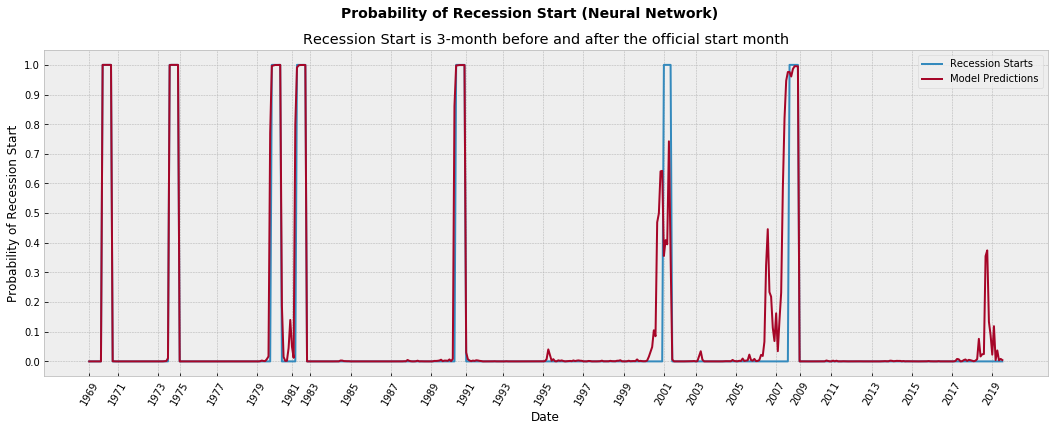

In [223]:
y_pred = model.predict(Xmm.values)[:,1]
fig = plt.figure(figsize=(18,6))
fig.suptitle('Probability of Recession Start (Neural Network)', fontsize=14, fontweight='bold')
ax = fig.add_subplot()
ax.set_title('Recession Start is 3-month before and after the official start month')
ax.plot(y.values, label="Recession Starts")
ax.plot(y_pred, label="Model Predictions")
ax.set_xlabel("Date")
ax.set_ylabel("Probability of Recession Start")
ax.locator_params(axis='y', tight=True, min_n_ticks=11)
ax.set_xticks(xt)
ax.set_xticklabels(xtl)
ax.tick_params(axis='x', labelrotation=60)
ax.legend()
plt.show()

In [81]:

log_loss(y_test, model.predict(X_test))

0.058340214614540885

In [196]:
# model 7a - 3 hl 900 n
# model 7b - 2 hl 1400 n
# model 7c - 2 hl 500 n
# model 7d - 2 hl 200 n
# model 7e - 2 hl 100 n
# model 7f - 1 hl 600 n
model.save('../models/model7e-082919.h5')

In [222]:
model = load_model('../models/model7c-082919.h5')

In [79]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 1800)              3285000   
_________________________________________________________________
dense_12 (Dense)             (None, 1800)              3241800   
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 3602      
Total params: 6,530,402
Trainable params: 6,530,402
Non-trainable params: 0
_________________________________________________________________


In [265]:
# create score table for the models and different metrics
def prob_rec(y_pred_proba):
    return y_pred_proba[-1,1]

models = ['lr', 'rf', 'sv', 'kn', 'nn']
metrics = [log_loss, f1_score, roc_auc_score, my_score, prob_rec]
perf = pd.DataFrame(columns=['Log_Reg', 'Rand_For', 'Sup_Vec', 'K_Near', 'Neur_Net'], \
                    index=['log_loss', 'f1_score', 'roc_auc_score', 'my_score', 'prob_rec'])    

In [266]:
for i, mod in list(enumerate(models)):
    for j, met in list(enumerate(metrics)):
        if j == 0:
            perf.iloc[j, i] = met(y_test, globals()[mod+'_pred_proba'])
        elif j==4:
            perf.iloc[j, i] = met(globals()[mod+'_pred_proba'])
        elif j==2:
            perf.iloc[j, i] = met(y_test, globals()[mod+'_pred_proba'][:,1])
        else:
            perf.iloc[j, i] = met(y_test, globals()[mod+'_pred'])
perf['Mean'] = perf.mean(axis=1)
perf.infer_objects().round(3)

,Log_Reg,Rand_For,Sup_Vec,K_Near,Neur_Net,Mean
log_loss,0.034,0.128,0.092,0.676,0.083,0.203
f1_score,0.800,0.286,0.500,0.000,0.750,0.467
roc_auc_score,0.999,0.999,0.999,0.738,0.999,0.947
my_score,0.833,0.583,0.667,0.000,0.000,0.417
prob_rec,0.012,0.086,0.093,0.000,0.005,0.039


In [267]:
# score table after dropping KNN
perf_nokn = perf.drop(['K_Near', 'Mean'], axis=1)
perf_nokn['Mean'] = perf_nokn.mean(axis=1)
perf_nokn.infer_objects().round(3)

,Log_Reg,Rand_For,Sup_Vec,Neur_Net,Mean
log_loss,0.034,0.128,0.092,0.083,0.084
f1_score,0.800,0.286,0.500,0.750,0.584
roc_auc_score,0.999,0.999,0.999,0.999,0.999
my_score,0.833,0.583,0.667,0.000,0.521
prob_rec,0.012,0.086,0.093,0.005,0.049


## test section to see standardization affects scaling and vice versa

In [44]:
t = np.random.normal(size=10)

In [45]:
t

array([ 0.23185185, -1.84780292, -0.45125223, -0.83734352,  0.05150387,
        0.19294269,  0.14582439,  2.37754756,  0.17724146, -1.06051392])

In [46]:
t_scale = preprocessing.scale(t)
t_minmax = preprocessing.minmax_scale(t, feature_range=(-1,1))
t_maxabs = preprocessing.maxabs_scale(t)

In [52]:
print(np.mean(t))
print(np.std(t))
print(np.mean(t_scale))
print(np.std(t_scale))
print(np.mean(t_minmax))
print(np.std(t_minmax))
print(np.mean(t_maxabs))
print(np.std(t_maxabs))
print(np.mean(preprocessing.maxabs_scale(t_scale)))
print(np.std(preprocessing.maxabs_scale(t_scale)))
print(np.mean(preprocessing.minmax_scale(t_scale, feature_range=(-1,1))))
print(np.std(preprocessing.minmax_scale(t_scale, feature_range=(-1,1))))

-0.10200007744358812
1.0554072429642678
5.551115123125783e-17
1.0
-0.1736530013663073
0.49955962190999914
-0.04290138263597604
0.44390583911303577
4.9960036108132046e-17
0.42564507680586783
-0.1736530013663073
0.49955962190999914


In [53]:
t

array([ 0.23185185, -1.84780292, -0.45125223, -0.83734352,  0.05150387,
        0.19294269,  0.14582439,  2.37754756,  0.17724146, -1.06051392])

In [54]:
t_scale

array([ 0.31632522, -1.6541509 , -0.33091696, -0.69673906,  0.14544523,
        0.27945873,  0.23481407,  2.34937523,  0.26458179, -0.90819336])

In [55]:
t_minmax

array([-0.01562969, -1.        , -0.33896575, -0.5217157 , -0.10099444,
       -0.03404671, -0.05634937,  1.        , -0.04147862, -0.62734973])

In [56]:
t_maxabs

array([ 0.09751723, -0.77718863, -0.18979735, -0.35218792,  0.02166261,
        0.08115198,  0.06133395,  1.        ,  0.07454802, -0.44605372])

In [57]:
preprocessing.scale(t_minmax)

array([ 0.31632522, -1.6541509 , -0.33091696, -0.69673906,  0.14544523,
        0.27945873,  0.23481407,  2.34937523,  0.26458179, -0.90819336])

In [58]:
preprocessing.minmax_scale(t_scale, feature_range=(-1,1))

array([-0.01562969, -1.        , -0.33896575, -0.5217157 , -0.10099444,
       -0.03404671, -0.05634937,  1.        , -0.04147862, -0.62734973])

In [59]:
preprocessing.scale(t_maxabs)

array([ 0.31632522, -1.6541509 , -0.33091696, -0.69673906,  0.14544523,
        0.27945873,  0.23481407,  2.34937523,  0.26458179, -0.90819336])

In [60]:
preprocessing.maxabs_scale(t_scale)

array([ 0.13464227, -0.70408119, -0.14085317, -0.29656355,  0.06190805,
        0.11895023,  0.09994745,  1.        ,  0.11261794, -0.38656803])

## Make various charts below for the report

In [268]:
# make plot of last two recessions only, to show predictions
j=1996
xt2=[]
xtl2=[]
for i,yr in enumerate(list(pd.to_datetime(y.loc[mid5_6:].index).year)):
    if yr==j:
        xt2.append(i)
        xtl2.append(yr)
        if j==2018:
            j += 1
        else:
            j += 2

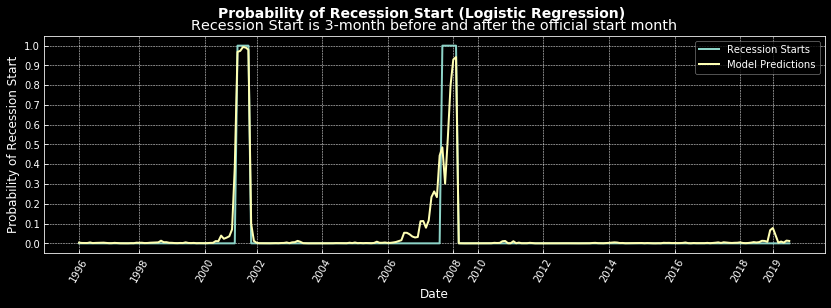

In [270]:
y_pred = lr_clf.predict_proba(X.loc[mid5_6:])[:,1]
mpl.style.use('dark_background')
fig = plt.figure(figsize=(14,4))
fig.suptitle('Probability of Recession Start (Logistic Regression)', fontsize=14, fontweight='bold')
ax = fig.add_subplot()
ax.set_title('Recession Start is 3-month before and after the official start month')
ax.plot(y.loc[mid5_6:].values, label="Recession Starts")
ax.plot(y_pred, label="Model Predictions")
ax.set_xlabel("Date")
ax.set_ylabel("Probability of Recession Start")
ax.locator_params(axis='y', tight=True, min_n_ticks=11)
ax.set_xticks(xt2)
ax.set_xticklabels(xtl2)
ax.tick_params(axis='x', labelrotation=60)
ax.legend()
plt.show()

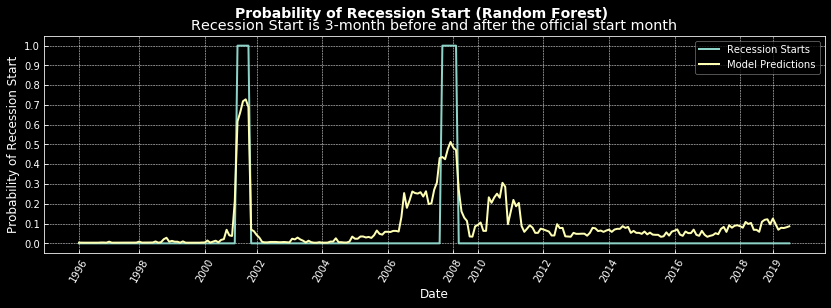

In [272]:
y_pred = rf_clf.predict_proba(X.loc[mid5_6:])[:,1]
mpl.style.use('dark_background')
fig = plt.figure(figsize=(14,4))
fig.suptitle('Probability of Recession Start (Random Forest)', fontsize=14, fontweight='bold')
ax = fig.add_subplot()
ax.set_title('Recession Start is 3-month before and after the official start month')
ax.plot(y.loc[mid5_6:].values, label="Recession Starts")
ax.plot(y_pred, label="Model Predictions")
ax.set_xlabel("Date")
ax.set_ylabel("Probability of Recession Start")
ax.locator_params(axis='y', tight=True, min_n_ticks=11)
ax.set_xticks(xt2)
ax.set_xticklabels(xtl2)
ax.tick_params(axis='x', labelrotation=60)
ax.legend()
plt.show()

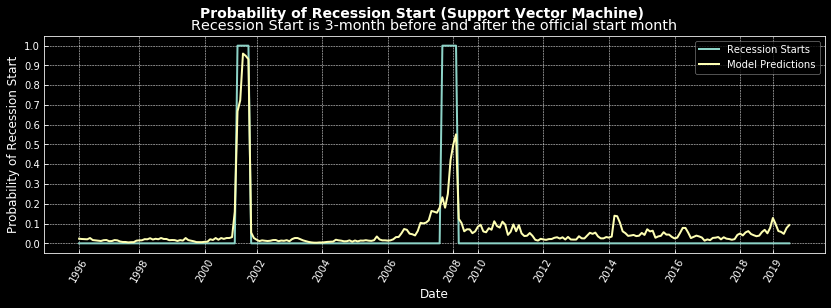

In [274]:
y_pred = svc_clf.predict_proba(X.loc[mid5_6:])[:,1]
mpl.style.use('dark_background')
fig = plt.figure(figsize=(14,4))
fig.suptitle('Probability of Recession Start (Support Vector Machine)', fontsize=14, fontweight='bold')
ax = fig.add_subplot()
ax.set_title('Recession Start is 3-month before and after the official start month')
ax.plot(y.loc[mid5_6:].values, label="Recession Starts")
ax.plot(y_pred, label="Model Predictions")
ax.set_xlabel("Date")
ax.set_ylabel("Probability of Recession Start")
ax.locator_params(axis='y', tight=True, min_n_ticks=11)
ax.set_xticks(xt2)
ax.set_xticklabels(xtl2)
ax.tick_params(axis='x', labelrotation=60)
ax.legend()
plt.show()

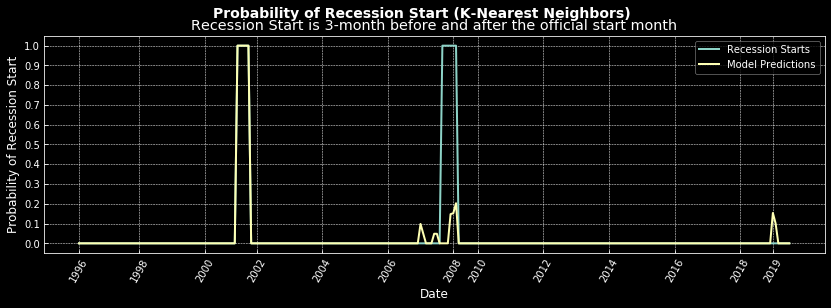

In [275]:
y_pred = kn_clf.predict_proba(X.loc[mid5_6:])[:,1]
mpl.style.use('dark_background')
fig = plt.figure(figsize=(14,4))
fig.suptitle('Probability of Recession Start (K-Nearest Neighbors)', fontsize=14, fontweight='bold')
ax = fig.add_subplot()
ax.set_title('Recession Start is 3-month before and after the official start month')
ax.plot(y.loc[mid5_6:].values, label="Recession Starts")
ax.plot(y_pred, label="Model Predictions")
ax.set_xlabel("Date")
ax.set_ylabel("Probability of Recession Start")
ax.locator_params(axis='y', tight=True, min_n_ticks=11)
ax.set_xticks(xt2)
ax.set_xticklabels(xtl2)
ax.tick_params(axis='x', labelrotation=60)
ax.legend()
plt.show()

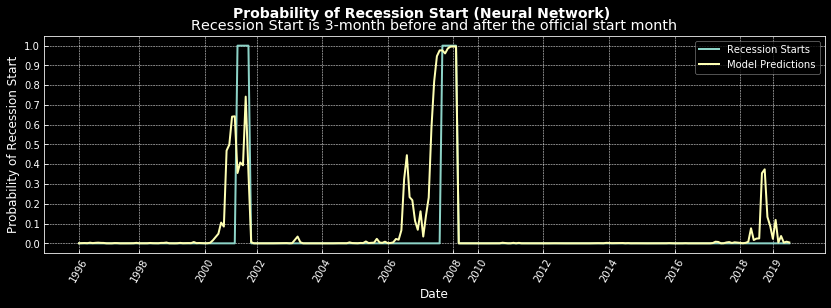

In [277]:
y_pred = model.predict(Xmm.loc[mid5_6:].values)[:,1]
mpl.style.use('dark_background')
fig = plt.figure(figsize=(14,4))
fig.suptitle('Probability of Recession Start (Neural Network)', fontsize=14, fontweight='bold')
ax = fig.add_subplot()
ax.set_title('Recession Start is 3-month before and after the official start month')
ax.plot(y.loc[mid5_6:].values, label="Recession Starts")
ax.plot(y_pred, label="Model Predictions")
ax.set_xlabel("Date")
ax.set_ylabel("Probability of Recession Start")
ax.locator_params(axis='y', tight=True, min_n_ticks=11)
ax.set_xticks(xt2)
ax.set_xticklabels(xtl2)
ax.tick_params(axis='x', labelrotation=60)
ax.legend()
plt.show()